In [ ]:
import numpy as np
import flopy as fp
import matplotlib.pyplot as plt
%matplotlib inline
import os, shutil
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
model_dir = 'theis_flopy_mf6_unstruc2'
model_name = 'theis'

In [ ]:
# create simulation
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)


In [ ]:
# create tdis package
tdis_rc = [(86400.0, 75, 1.2)]
tdis = fp.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             perioddata=tdis_rc)

In [ ]:
# create gwf model
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
gwf.name_file.save_flows = True

In [ ]:
# create iterative model solution and register the gwf model with it
ims = fp.mf6.ModflowIms(sim, pname='ims', print_option='SUMMARY', 
                           complexity='SIMPLE', outer_hclose=1.e-2, 
                           outer_maximum=10, under_relaxation='NONE', 
                           inner_maximum=10, inner_hclose=1.e-4, 
                           rcloserecord=0.1, linear_acceleration='BICGSTAB', 
                           scaling_method='NONE', reordering_method='NONE', 
                           relaxation_factor=0.99)

In [7]:
sim.register_ims_package(ims, [gwf.name])


In [8]:
1001*100/52

1925.0

In [9]:
# dis
nlay = 1
nrow = 52
ncol = 52
delr = 1925
delc = 1925
top = 0
botm = -1
simfake = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)
gwffake = fp.mf6.ModflowGwf(simfake, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwffake, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm)

In [10]:
if os.path.exists(model_dir):
    shutil.rmtree(model_dir)
os.mkdir(model_dir)
    

In [11]:
from flopy.utils.gridgen import Gridgen 
g = Gridgen(dis, model_ws=model_dir, exe_name='gridgen')

In [12]:
def make_circle(r,steps=100, cx=nrow*delr/2,cy=nrow*delr/2):
    x = np.arange(-r,r+r/steps,r/steps)
    y = np.sqrt(r**2-x**2)
    x = np.hstack((x,np.flipud(x[:-1])))
    y = np.hstack((y,-y[:-1]))
    return x+cx,y+cy

In [13]:
# create circular polygons around the well for refinement
rf0shp = os.path.join(model_dir, 'rf0')
x0,y0 = make_circle(7*delr)
rf1shp = os.path.join(model_dir, 'rf1')
x1,y1 = make_circle(5*delr)
rf2shp = os.path.join(model_dir, 'rf2')
x2,y2 = make_circle(3*delr)
rf3shp = os.path.join(model_dir, 'rf3')
x3,y3 = make_circle(1*delr)


In [14]:
g.add_refinement_features([[list(zip(x0,y0))]], 'polygon', 1, range(nlay))
g.add_refinement_features([[list(zip(x1,y1))]], 'polygon', 2, range(nlay))
g.add_refinement_features([[list(zip(x2,y2))]], 'polygon', 3, range(nlay))
g.add_refinement_features([[list(zip(x3,y3))]], 'polygon', 4, range(nlay))

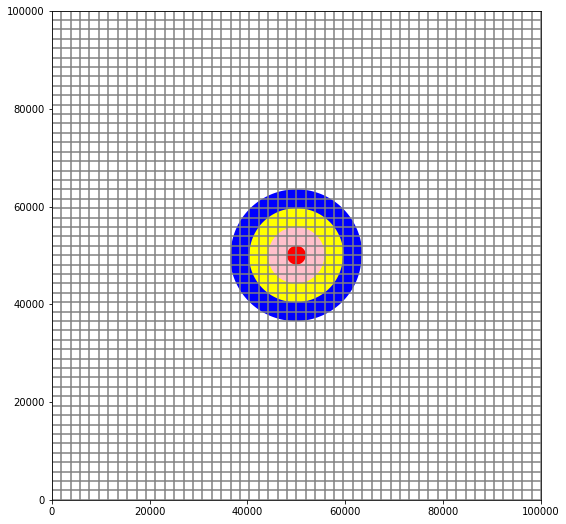

In [15]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(model=gwffake)#, extent = (30 * delr,70 * delr,30 * delc, 70 * delc))
mm.plot_grid()
fp.plot.plot_shapefile(rf0shp, ax=ax, facecolor='blue', edgecolor='none')
fp.plot.plot_shapefile(rf1shp, ax=ax, facecolor='yellow', edgecolor='none')
fp.plot.plot_shapefile(rf2shp, ax=ax, facecolor='pink', edgecolor='none')
fp.plot.plot_shapefile(rf3shp, ax=ax, facecolor='red', edgecolor='none')

(35227.5, 64872.5, 35227.5, 64872.5)

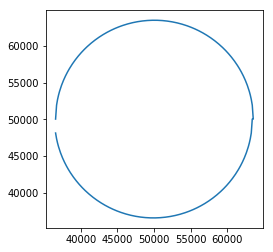

In [16]:
plt.plot(x0,y0)
plt.axis('square')

In [17]:
g.build()

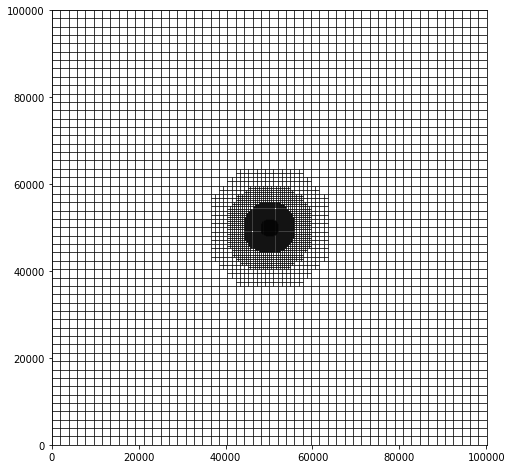

In [18]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5)
#plt.xlim((20*delr,30*delr))
#plt.ylim((20*delc,30*delc))

In [19]:
gridprops = g.get_gridprops_disv()
ncpl = gridprops['ncpl']
top = gridprops['top']
botm = gridprops['botm']
nvert = gridprops['nvert']
vertices = gridprops['vertices']
cell2d = gridprops['cell2d']


In [20]:
# initial conditions
ic = fp.mf6.ModflowGwfic(gwf, pname='ic', strt=0.)

In [21]:
gwf

name = theis
model_type = gwf6
version = mf6
model_relative_path = .

###################
Package ic
###################

package_name = ic
filename = theis.ic
package_type = ic
model_or_simulation_package = model
model_name = theis



In [22]:
# disv
disv = fp.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, 
                                top=0, botm=botm, 
                                nvert=nvert, vertices=vertices, 
                                cell2d=cell2d)

In [23]:
len(top)

6394

In [24]:
cell2d

[(0, 962.5, 99137.5, 5, 0, 1, 2, 3, 0, None, None),
 (1, 2887.5, 99137.5, 5, 1, 4, 5, 2, 1, None, None),
 (2, 4812.5, 99137.5, 5, 4, 6, 7, 5, 4, None, None),
 (3, 6737.5, 99137.5, 5, 6, 8, 9, 7, 6, None, None),
 (4, 8662.5, 99137.5, 5, 8, 10, 11, 9, 8, None, None),
 (5, 10587.5, 99137.5, 5, 10, 12, 13, 11, 10, None, None),
 (6, 12512.5, 99137.5, 5, 12, 14, 15, 13, 12, None, None),
 (7, 14437.5, 99137.5, 5, 14, 16, 17, 15, 14, None, None),
 (8, 16362.5, 99137.5, 5, 16, 18, 19, 17, 16, None, None),
 (9, 18287.5, 99137.5, 5, 18, 20, 21, 19, 18, None, None),
 (10, 20212.5, 99137.5, 5, 20, 22, 23, 21, 20, None, None),
 (11, 22137.5, 99137.5, 5, 22, 24, 25, 23, 22, None, None),
 (12, 24062.5, 99137.5, 5, 24, 26, 27, 25, 24, None, None),
 (13, 25987.5, 99137.5, 5, 26, 28, 29, 27, 26, None, None),
 (14, 27912.5, 99137.5, 5, 28, 30, 31, 29, 28, None, None),
 (15, 29837.5, 99137.5, 5, 30, 32, 33, 31, 30, None, None),
 (16, 31762.5, 99137.5, 5, 32, 34, 35, 33, 32, None, None),
 (17, 33687.5, 9913

In [25]:
chd_spd = [i for i in cell2d if i[1] == delr/2] + \
[i for i in cell2d if i[2] == delr/2] + \
[i for i in cell2d if i[1] == ((nrow * delr-1)+delr/2)] + \
[i for i in cell2d if i[2] == ((nrow * delr-1)+delr/2)] 


In [26]:
print(len(chd_spd))
chd_spd = list(set(chd_spd))
chd_spd = [[[0,i[0]],0] for i in chd_spd]
print(len(chd_spd))


104
103


In [27]:
chd = fp.mf6.ModflowGwfchd(gwf, save_flows=True,stress_period_data = chd_spd)

In [28]:
# npf 
hk=0.3

# node property flow
npf = fp.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True,
                              icelltype=[0], 
                              k=[hk],
                              k33=[hk])

In [29]:
# storage
ss=0.0008
stor = fp.mf6.ModflowGwfsto(gwf, ss=ss, transient=True)

In [30]:
x = [i[1] for i in cell2d]
y = [i[2] for i in cell2d]
xc= x==np.median(x)
yc =y==np.median(y)

In [31]:
np.argmin(np.abs(np.array(x)-48500))

1618

In [32]:
np.argmin(np.abs(np.array(y)-48500))

3287

In [33]:
cell2d[1741]

(1741, 51614.0625, 54260.9375, 5, 1869, 1872, 1878, 1875, 1869, None, None)

In [34]:
cell2d[1716]

(1716, 50410.9375, 54501.5625, 5, 1850, 1851, 1853, 1852, 1850, None, None)

In [35]:
center_cell = gwf.modelgrid.intersect(np.median(x),np.median(y))

In [36]:
np.median(y)

49989.84375

In [37]:
np.where(y==np.median(y))

(array([3375, 3376, 3379, 3380, 3391, 3392, 3395, 3396, 3439, 3440, 3443,
        3444, 3455, 3456, 3459, 3460, 3610, 3611, 3614, 3615, 3626, 3627,
        3630, 3631, 3674, 3675, 3678, 3679, 3690, 3691, 3694, 3695]),)

In [38]:
np.where(xc == True)

(array([2598, 2600, 2606, 2608, 2630, 2632, 2638, 2640, 2726, 2728, 2734,
        2736, 2758, 2760, 2766, 2768, 3460, 3462, 3468, 3470, 3492, 3494,
        3500, 3502, 3567, 3569, 3575, 3577, 3599, 3601, 3607, 3609]),)

In [39]:
cell2d[1311]

(1311, 22137.5, 56787.5, 5, 1243, 1244, 1416, 1415, 1243, None, None)

In [40]:
np.unique(xc.astype(int) * yc.astype(int))

array([0, 1])

In [41]:
# single well in the center
well_sp = [[(0, center_cell), -1.16]]
wel = fp.mf6.ModflowGwfwel(gwf,save_flows=True,stress_period_data=well_sp)

In [42]:
# output control
oc = fp.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [43]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model theis...
    writing model name file...
    writing package ic...
    writing package disv...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 103 based on size of stress_period_data
    writing package npf...
    writing package sto...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/bin/MAC_VERSIONS_USGS/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 


(True, [])

In [44]:
fname = os.path.join(model_dir, model_name + '.hds')
hdobj = fp.utils.HeadFile(fname)
head = hdobj.get_alldata()

In [45]:
head.shape

(75, 1, 1, 6394)

In [46]:
cell2d[1775]

(1775, 52095.3125, 54020.3125, 5, 1879, 1913, 1915, 1881, 1879, None, None)

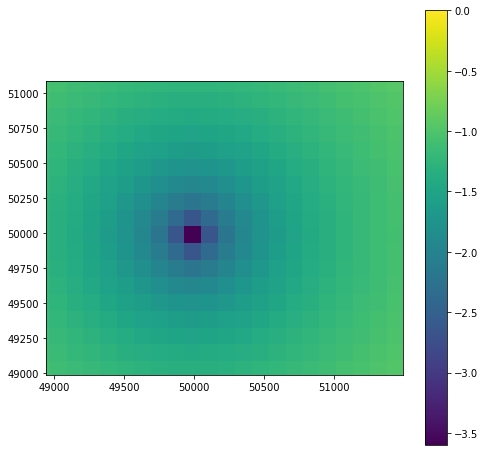

In [48]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(gwf, ax=ax)
xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
v=mm.plot_array(head[74,0,0:])
plt.xlim((xmid-1050,xmid+1500))
plt.ylim((ymid-1000,ymid+1100))
plt.colorbar(v)


In [ ]:
'''
with PdfPages('theis_mf.pdf') as pdfout:
    for i, chead in enumerate(head):
        printhead = np.squeeze(chead)
        plt.figure(figsize=(8,8))
        plt.imshow(-printhead[490:510,490:510],
                  interpolation='nearest',
                  vmin=0,
                  vmax=2.7)
        plt.colorbar()
        plt.title('Theis-o-matic --> timestep{0}'.format(i))
        pdfout.savefig()
        plt.close()
'''        

In [ ]:
alltimes = hdobj.get_times()

In [ ]:
import theis_script2

In [ ]:
dd_analytical = theis_script2.theis_analytical(alltimes)

In [ ]:
with PdfPages('theis_modflow_unstructured_analytical.pdf') as pdfout:
    for i in range(len(alltimes)):
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(121)
        mm = fp.plot.PlotMapView(gwf, ax=ax)
        ax.set_aspect('equal')
        xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
        v=mm.plot_array(-head[i,0,:],vmin=0,vmax=1.7, cmap='magma')
        ax.set_xlim((xmid-1050,xmid+1050))
        ax.set_ylim((ymid-1050,ymid+1050))

        plt.title('MODFLOW6 Unstructured')
        fig.add_subplot(122)
        plt.imshow(dd_analytical[i], interpolation='nearest',
                  vmin=0,
                  vmax=1.7, cmap='magma')
        plt.title('Analytical')
        plt.suptitle('Theis two ways: timestep = {0}'.format(i+1))
        plt.tight_layout()
        
        pdfout.savefig()
        plt.close()